success_rate, time_taken, distance_travelled, straight_distance, (optimal_time or dijsktra_time)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df = pd.read_csv('data_sorted.csv')
df.head()

FileNotFoundError: [Errno 2] File b'data_sorted.csv' does not exist: b'data_sorted.csv'

In [2]:
df.describe()

,actual_time,optimal_time,goal_x,goal_y,world_idx,lidar_0,lidar_1,lidar_2,lidar_3,lidar_4,...,lidar_718,lidar_719,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular,timestep
count,202569.000000,202569.000000,202569.0,202569.0,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,...,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000,202569.000000
mean,12.902522,5.715869,0.0,10.0,151.958370,4.115800,4.135718,4.152697,4.171695,4.190318,...,4.341831,4.328646,-0.040379,4.130155,1.548915,0.704698,-0.003710,0.705616,-0.002722,343.772685
std,2.451819,0.375246,0.0,0.0,87.229118,6.490961,6.553439,6.610645,6.670345,6.728279,...,7.042407,6.992671,0.530169,2.789321,0.385390,0.211738,0.259670,0.208302,0.233824,210.896994
min,11.784000,5.026614,0.0,10.0,0.000000,0.292403,0.291040,0.289275,0.287048,0.286279,...,0.292182,0.293237,-1.714366,-0.000258,-3.141397,-0.337823,-2.126267,-0.300000,-1.570796,0.000000
25%,11.937000,5.446358,0.0,10.0,76.000000,1.691495,1.684698,1.677570,1.671675,1.666527,...,1.601476,1.608613,-0.308475,1.634119,1.465763,0.799501,-0.062289,0.800000,-0.067353,168.000000
50%,12.136000,5.617254,0.0,10.0,153.000000,2.879177,2.865790,2.851509,2.837667,2.824436,...,2.823026,2.836414,-0.006654,4.026890,1.578731,0.800233,-0.001211,0.800000,0.000042,337.000000
75%,12.518000,5.922971,0.0,10.0,228.000000,3.195433,3.179926,3.163331,3.149627,3.134901,...,3.162534,3.180164,0.208518,6.519710,1.678931,0.801077,0.044440,0.800000,0.052444,506.000000
max,26.686000,6.867653,0.0,10.0,299.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,1.653924,9.367064,3.140065,0.811978,2.186863,0.800000,1.570796,1375.000000


In [3]:
# torch Dataset
from torch.utils.data import Dataset
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class KULBarnDataset(Dataset):
    def get_local_goal(self):
        x = self.data['pos_x']
        y = self.data['pos_y']
        theta = self.data['pose_heading']
        goal_x = self.data['goal_x']
        goal_y = self.data['goal_y']
        self.data['local_x'] = (goal_x - x) * np.cos(theta) + (goal_y - y) * np.sin(theta)
        self.data['local_y'] = -(goal_x - x) * np.sin(theta) + (goal_y - y) * np.cos(theta)
    
    def __init__(self, df, scaler=None):
        super().__init__()

        self.data = df
        self.get_local_goal()   
        self.data = self.data.drop(columns=[
            'world_idx', 'timestep', 'actual_time', 'optimal_time', 
            'pos_x', 'pos_y', 'pose_heading', 'goal_x', 'goal_y', 'success'
        ])

        # get all the column values that contain the word lidar
        self.lidar_cols = [col for col in self.data.columns if 'lidar' in col]
        # get actions columns
        self.actions_cols = [col for col in self.data.columns if 'cmd' in col]
        # get other columns
        self.non_lidar_cols = [col for col in self.data.columns if col not in self.lidar_cols and col not in self.actions_cols]
        print("Lidar Columns:", self.lidar_cols)
        print("Non Lidar Columns:", self.non_lidar_cols)
        print("Action Columns:", self.actions_cols)

        self.cols_order = self.lidar_cols + self.non_lidar_cols + self.actions_cols
        self.data = self.data[self.cols_order]
        print(self.data.head())
        
        if scaler is None:
            self.scaler = MinMaxScaler()
            self.scaler.fit(self.data)
        else:
            self.scaler = scaler
        self.data = pd.DataFrame(self.scaler.transform(self.data), columns=self.data.columns)
        
        self.lidar_data = self.data[self.lidar_cols].values
        self.non_lidar_data = self.data[self.non_lidar_cols].values
        self.actions_data = self.data[self.actions_cols].values

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        lidar = self.lidar_data[idx]
        non_lidar = self.non_lidar_data[idx]
        actions = self.actions_data[idx]
        return lidar, non_lidar, actions

In [4]:
# split train and test
import random
# set random seed
random.seed(42)

NO_WORLDS = 300
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO = 0.2

world_ids = [i for i in range(NO_WORLDS)]
test_ids = [id for id in range(0, NO_WORLDS, 5)]
train_evals = [id for id in world_ids if id not in test_ids]
train_ids = random.sample(train_evals, int(NO_WORLDS * TRAIN_RATIO))
val_ids = [id for id in train_evals if id not in train_ids]

train_df = df[df['world_idx'].isin(train_ids)]
val_df = df[df['world_idx'].isin(val_ids)]

In [5]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

210
30
60


In [6]:
print(len(train_df))
print(len(val_df))

141967
20248


In [7]:
train_dataset = KULBarnDataset(train_df)
scaler = train_dataset.scaler
val_dataset = KULBarnDataset(val_df, scaler)

Lidar Columns: ['lidar_0', 'lidar_1', 'lidar_2', 'lidar_3', 'lidar_4', 'lidar_5', 'lidar_6', 'lidar_7', 'lidar_8', 'lidar_9', 'lidar_10', 'lidar_11', 'lidar_12', 'lidar_13', 'lidar_14', 'lidar_15', 'lidar_16', 'lidar_17', 'lidar_18', 'lidar_19', 'lidar_20', 'lidar_21', 'lidar_22', 'lidar_23', 'lidar_24', 'lidar_25', 'lidar_26', 'lidar_27', 'lidar_28', 'lidar_29', 'lidar_30', 'lidar_31', 'lidar_32', 'lidar_33', 'lidar_34', 'lidar_35', 'lidar_36', 'lidar_37', 'lidar_38', 'lidar_39', 'lidar_40', 'lidar_41', 'lidar_42', 'lidar_43', 'lidar_44', 'lidar_45', 'lidar_46', 'lidar_47', 'lidar_48', 'lidar_49', 'lidar_50', 'lidar_51', 'lidar_52', 'lidar_53', 'lidar_54', 'lidar_55', 'lidar_56', 'lidar_57', 'lidar_58', 'lidar_59', 'lidar_60', 'lidar_61', 'lidar_62', 'lidar_63', 'lidar_64', 'lidar_65', 'lidar_66', 'lidar_67', 'lidar_68', 'lidar_69', 'lidar_70', 'lidar_71', 'lidar_72', 'lidar_73', 'lidar_74', 'lidar_75', 'lidar_76', 'lidar_77', 'lidar_78', 'lidar_79', 'lidar_80', 'lidar_81', 'lidar_82'

In [8]:
import pickle

# Save the scaler to a file
scaler_path = 'model/scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Scaler saved to {scaler_path}")

Scaler saved to scaler.pkl


In [8]:
print("Train Dataset Length:", len(train_dataset))
print("Val Dataset Length:", len(val_dataset))

Train Dataset Length: 141967
Val Dataset Length: 20248


In [9]:
# dataloader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test dataloader
lidar, non_lidar, actions = next(iter(train_loader))
print(f"Non lidar shape: {non_lidar.shape}")
print(f"Lidar shape: {lidar.shape}")
# print size dataloader
print(f"Train loader size: {len(train_loader)}")
print(f"Val loader size: {len(val_loader)}")
print(lidar, non_lidar, actions)

Non lidar shape: torch.Size([64, 4])
Lidar shape: torch.Size([64, 720])
Train loader size: 2219
Val loader size: 317
tensor([[0.0758, 0.0755, 0.0741,  ..., 0.1305, 0.1334, 0.1340],
        [0.1382, 0.1406, 0.1396,  ..., 0.0721, 0.0718, 0.0718],
        [0.0745, 0.0742, 0.0742,  ..., 0.1258, 0.1257, 0.1258],
        ...,
        [0.0926, 0.0928, 0.0930,  ..., 0.0886, 0.0885, 0.0886],
        [0.0999, 0.0993, 0.0991,  ..., 0.0799, 0.0799, 0.0801],
        [0.1445, 0.1458, 0.1579,  ..., 1.0000, 1.0000, 1.0000]],
       dtype=torch.float64) tensor([[0.9951, 0.5561, 0.8954, 0.3516],
        [0.3367, 0.4099, 0.8572, 0.7762],
        [0.9942, 0.5300, 0.8239, 0.1891],
        [0.9948, 0.4840, 0.8966, 0.4781],
        [0.9895, 0.4831, 0.4893, 0.5174],
        [0.9932, 0.4757, 0.8911, 0.4495],
        [0.3565, 0.4818, 0.9993, 0.5126],
        [0.6107, 0.5083, 0.9780, 0.6082],
        [0.9895, 0.5116, 0.6117, 0.5085],
        [0.9894, 0.4909, 0.5080, 0.5051],
        [0.9923, 0.5012, 0.8529, 0.50

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_lidar_features, num_non_lidar_features, num_actions, nframes=1):
        super(CNNModel, self).__init__()
        self.act_fea_cv1 = nn.Conv1d(
            in_channels=nframes, out_channels=32, kernel_size=5, stride=2, padding=6, padding_mode='circular'
        )
        self.act_fea_cv2 = nn.Conv1d(
            in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1
        )

        conv_output_size = (num_lidar_features - 5 + 2*6) // 2 + 1  # Output size after self.act_fea_cv1
        conv_output_size = (conv_output_size - 3 + 2*1) // 2 + 1  # Output size after self.act_fea_cv2
        conv_output_size *= 32  # Multiply by the number of output channels

        # Calculate the output size of the CNN
        self.fc1 = nn.Linear(conv_output_size, 32)
        self.fc2 = nn.Linear(32 + num_non_lidar_features, num_actions)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, lidar, non_lidar):
        lidar = lidar.unsqueeze(1)  # Add channel dimension
        feat = F.relu(self.act_fea_cv1(lidar))
        feat = F.relu(self.act_fea_cv2(feat))
        feat = feat.view(feat.shape[0], -1)
        feat = F.relu(self.fc1(feat))
        feat = torch.cat((feat, non_lidar), dim=-1)
        feat = F.relu(self.fc2(feat))
        return feat

In [11]:
# Initialize the model
num_lidar_features = len(train_dataset.lidar_cols)
num_non_lidar_features = len(train_dataset.non_lidar_cols)
num_actions = len(train_dataset.actions_cols)
model = CNNModel(num_lidar_features, num_non_lidar_features, num_actions)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cuda


In [12]:
from tqdm import tqdm

def train_model(model, train_loader, loss_fn, optimizer):
    model.train()

    losses = []
    for lidar, non_lidar, actions in tqdm(train_loader):

        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [13]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions in tqdm(test_loader):
        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [14]:
import sys
NUM_EPOCHS = 0

random_val_loss = test_model(model, val_loader, loss_fn)
print("Random val loss:", random_val_loss)
sys.stdout.flush()

cnn_train_losses = []
cnn_val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    test_loss = test_model(model, val_loader, loss_fn)
    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {test_loss}")
    sys.stdout.flush()

100%|██████████| 317/317 [00:03<00:00, 94.61it/s] 

Random val loss: 0.5639771847083741



100%|██████████| 317/317 [00:00<00:00, 720.55it/s]

Epoch 1/5 | Train Loss: 0.0262248184149577 | Val Loss: 0.01389470227845476



100%|██████████| 317/317 [00:00<00:00, 861.52it/s]

Epoch 2/5 | Train Loss: 0.013439047578516584 | Val Loss: 0.012053156589504095



100%|██████████| 317/317 [00:00<00:00, 827.98it/s]

Epoch 3/5 | Train Loss: 0.010635137646645811 | Val Loss: 0.009937038048106608



100%|██████████| 317/317 [00:00<00:00, 818.40it/s]

Epoch 4/5 | Train Loss: 0.00855991780986013 | Val Loss: 0.008691339359151593



100%|██████████| 317/317 [00:00<00:00, 820.08it/s]

Epoch 5/5 | Train Loss: 0.007024553547816459 | Val Loss: 0.0077132053016090016


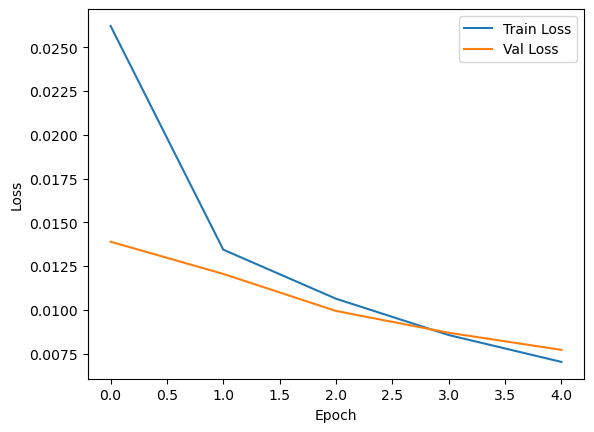

In [15]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [16]:
# save the model
torch.save(model.state_dict(), './model/cnn_model.pth')

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

class TransformerModel(nn.Module):
    def __init__(self, num_lidar_features, num_non_lidar_features, num_actions, d_model=64, nhead=8, num_encoder_layers=3, num_decoder_layers=3):
        super(TransformerModel, self).__init__()

        self.d_model = d_model
        self.num_patches = 20  # Number of patches
        self.patch_size = num_lidar_features // self.num_patches

        # Positional Encoding for the Encoder
        self.positional_encoding = nn.Parameter(torch.zeros(self.num_patches, d_model))

        # Input Embedding for Encoder (LiDAR data)
        self.lidar_embedding = nn.Linear(self.patch_size, d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Input Embedding for Decoder (Non-LiDAR data)
        self.non_lidar_embedding = nn.Linear(num_non_lidar_features, d_model)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Linear layer to map the transformer output to actions
        self.fc_out = nn.Linear(d_model, num_actions)

    def forward(self, lidar, non_lidar):
        batch_size = lidar.size(0)
        
        # Divide LiDAR input into patches
        lidar_patches = lidar.view(batch_size, self.num_patches, self.patch_size)

        # Embed each patch and add positional encoding
        lidar_embed = self.lidar_embedding(lidar_patches) + self.positional_encoding.unsqueeze(0)
        lidar_embed = lidar_embed.permute(1, 0, 2)  # Convert to (seq_len, batch_size, d_model)

        # Process through the transformer encoder
        memory = self.transformer_encoder(lidar_embed)

        # Process non-lidar data through input embedding
        non_lidar_embed = self.non_lidar_embedding(non_lidar).unsqueeze(0)  # Convert to (1, batch_size, d_model)

        # Process through the transformer decoder
        output = self.transformer_decoder(non_lidar_embed, memory)

        # Final linear layer to get the actions
        actions = self.fc_out(output.squeeze(0))
        return actions

In [18]:
# Initialize the model
num_lidar_features = len(train_dataset.lidar_cols)
num_non_lidar_features = len(train_dataset.non_lidar_cols)
num_actions = len(train_dataset.actions_cols)
model = TransformerModel(num_lidar_features, num_non_lidar_features, num_actions)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cuda


In [19]:
import sys
NUM_EPOCHS = 0

random_val_loss = test_model(model, val_loader, loss_fn)
print("Random val loss:", random_val_loss)

transformer_train_losses = []
transformer_val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    val_loss = test_model(model, val_loader, loss_fn)
    transformer_train_losses.append(train_loss)
    transformer_val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {test_loss}")
    sys.stdout.flush()

100%|██████████| 317/317 [00:01<00:00, 220.56it/s]


Random val loss: 0.23099632454266308


100%|██████████| 317/317 [00:01<00:00, 225.00it/s]

Epoch 1/5 | Train Loss: 0.00463109133180559 | Val Loss: 0.0077132053016090016



100%|██████████| 317/317 [00:01<00:00, 224.30it/s]

Epoch 2/5 | Train Loss: 0.0015717923007111194 | Val Loss: 0.0077132053016090016



100%|██████████| 317/317 [00:01<00:00, 224.42it/s]

Epoch 3/5 | Train Loss: 0.0012741511510154162 | Val Loss: 0.0077132053016090016



100%|██████████| 317/317 [00:01<00:00, 220.83it/s]

Epoch 4/5 | Train Loss: 0.0011282917552669803 | Val Loss: 0.0077132053016090016



100%|██████████| 317/317 [00:01<00:00, 223.90it/s]

Epoch 5/5 | Train Loss: 0.0010399389255444282 | Val Loss: 0.0077132053016090016


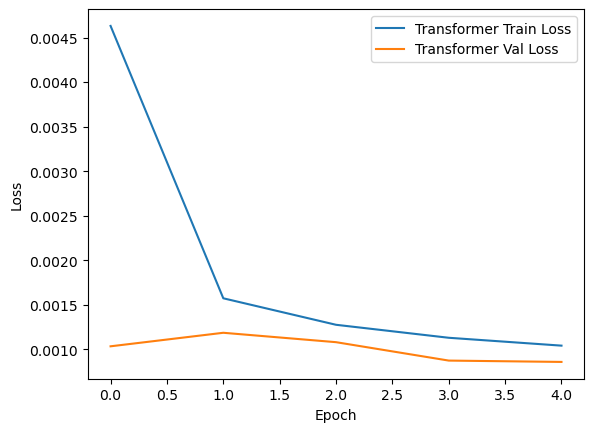

In [20]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(transformer_train_losses, label='Transformer Train Loss')
plt.plot(transformer_val_losses, label='Transformer Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [21]:
# save the model
torch.save(model.state_dict(), 'model/transformer_model.pth')

In [22]:
import os
import hydra
import torch
from omegaconf import OmegaConf
import pathlib
from torch.utils.data import DataLoader
import copy
import numpy as np
import random
import wandb
import tqdm
import shutil
from diffusion_policy.policy.diffusion_unet_lowdim_policy import DiffusionUnetLowdimPolicy
from diffusion_policy.workspace.train_diffusion_unet_lowdim_workspace import TrainDiffusionUnetLowdimWorkspace
import os

In [23]:
from diffusion_policy.dataset.base_dataset import BaseLowdimDataset
from typing import Dict
import torch
import numpy as np
import copy
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.common.replay_buffer import ReplayBuffer
from diffusion_policy.common.sampler import (
    SequenceSampler, get_val_mask, downsample_mask)
from diffusion_policy.model.common.normalizer import LinearNormalizer
from diffusion_policy.dataset.base_dataset import BaseLowdimDataset


class KULBarnDiffusionDataset(BaseLowdimDataset):
    def __init__(self, df, horizon=4):
        super().__init__()
        
        self.data = df
        self.get_local_goal()

        self.data = self.data.drop(columns=[
            'timestep', 'actual_time', 'optimal_time', 
            'pos_x', 'pos_y', 'pose_heading', 'goal_x', 'goal_y', 'success'
        ])
        
        self.data = pd.DataFrame(self.data, columns=self.data.columns)
        self.horizon = horizon

        # Process data columns
        self.lidar_cols = [col for col in self.data.columns if 'lidar' in col]
        self.actions_cols = [col for col in self.data.columns if 'cmd' in col]
        self.non_lidar_cols = [col for col in self.data.columns if col not in self.lidar_cols and col not in self.actions_cols and col != 'world_idx']

        self.lidar_data = self.data[self.lidar_cols].values
        self.non_lidar_data = self.data[self.non_lidar_cols].values
        self.actions_data = self.data[self.actions_cols].values

        print("Lidar Columns:", self.lidar_cols)
        print("Non Lidar Columns:", self.non_lidar_cols)
        print("Action Columns:", self.actions_cols)     

        self.grouped_data = self.data.groupby(self.data['world_idx'])
        self.horizon = horizon
        path_lengths = [len(group) for name, group in self.grouped_data]
        self.indices = self.make_indices(path_lengths, horizon)

    def get_local_goal(self):
        x = self.data['pos_x']
        y = self.data['pos_y']
        theta = self.data['pose_heading']
        goal_x = self.data['goal_x']
        goal_y = self.data['goal_y']
        self.data['local_x'] = (goal_x - x) * np.cos(theta) + (goal_y - y) * np.sin(theta)
        self.data['local_y'] = -(goal_x - x) * np.sin(theta) + (goal_y - y) * np.cos(theta)

    def make_indices(self, path_lengths, horizon):
        indices = []
        for i, path_length in enumerate(path_lengths):
            max_start = path_length - horizon
            for start in range(max_start):
                end = start + horizon
                indices.append((i, start, end))
        indices = np.array(indices)
        return indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        idx = self.indices[idx]
        start = idx[1]
        end = idx[2]

        data = {
            'obs': self.lidar_data[start:end],
            'cond': self.non_lidar_data[start:end],
            'action': self.actions_data[start:end],
        }
        torch_data = dict_apply(data, torch.from_numpy)
        return torch_data

    def get_normalizer(self, mode='limits', **kwargs):
        normalizer = LinearNormalizer()
        # train it in using self.data as a dictionary
        data_dict = {
            'obs': self.lidar_data,
            'cond': self.non_lidar_data,
            'action': self.actions_data
        }
        normalizer.fit(data=data_dict, mode=mode, **kwargs)
        return normalizer

    def get_all_actions(self) -> torch.Tensor:
        return torch.from_numpy(self.actions_data)

In [24]:
train_dataset = KULBarnDiffusionDataset(train_df)
train_dataloader = DataLoader(train_dataset)
normalizer = train_dataset.get_normalizer()
print(len(train_dataloader))

Lidar Columns: ['lidar_0', 'lidar_1', 'lidar_2', 'lidar_3', 'lidar_4', 'lidar_5', 'lidar_6', 'lidar_7', 'lidar_8', 'lidar_9', 'lidar_10', 'lidar_11', 'lidar_12', 'lidar_13', 'lidar_14', 'lidar_15', 'lidar_16', 'lidar_17', 'lidar_18', 'lidar_19', 'lidar_20', 'lidar_21', 'lidar_22', 'lidar_23', 'lidar_24', 'lidar_25', 'lidar_26', 'lidar_27', 'lidar_28', 'lidar_29', 'lidar_30', 'lidar_31', 'lidar_32', 'lidar_33', 'lidar_34', 'lidar_35', 'lidar_36', 'lidar_37', 'lidar_38', 'lidar_39', 'lidar_40', 'lidar_41', 'lidar_42', 'lidar_43', 'lidar_44', 'lidar_45', 'lidar_46', 'lidar_47', 'lidar_48', 'lidar_49', 'lidar_50', 'lidar_51', 'lidar_52', 'lidar_53', 'lidar_54', 'lidar_55', 'lidar_56', 'lidar_57', 'lidar_58', 'lidar_59', 'lidar_60', 'lidar_61', 'lidar_62', 'lidar_63', 'lidar_64', 'lidar_65', 'lidar_66', 'lidar_67', 'lidar_68', 'lidar_69', 'lidar_70', 'lidar_71', 'lidar_72', 'lidar_73', 'lidar_74', 'lidar_75', 'lidar_76', 'lidar_77', 'lidar_78', 'lidar_79', 'lidar_80', 'lidar_81', 'lidar_82'

In [25]:
for batch in train_dataloader:
    # print(batch)
    print(batch['obs'].shape)
    print(batch['cond'].shape)
    print(batch['action'].shape)
    break

torch.Size([1, 4, 720])
torch.Size([1, 4, 4])
torch.Size([1, 4, 2])


In [27]:
from diffusion_policy.policy.diffusion_unet_lidar_policy import DiffusionUnetLidarPolicy
from diffusion_policy.model.diffusion.conditional_unet1d import ConditionalUnet1D
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler

obs_dim = batch['obs'].shape[-1]
action_dim = batch['action'].shape[-1]
input_dim = obs_dim + action_dim
model = ConditionalUnet1D(input_dim=input_dim)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='linear')
horizon = 4
policy = DiffusionUnetLidarPolicy(
    model=model, 
    noise_scheduler=noise_scheduler, 
    horizon=horizon, 
    obs_dim=obs_dim, 
    action_dim=action_dim, 
    n_obs_steps=4,
    n_action_steps=4,
    pred_action_steps_only=False,
)

In [28]:
policy.set_normalizer(normalizer)

In [29]:
from tqdm import tqdm

NUM_EPOCHS = 10
losses = []
save_loss_every = 1000
total_loss = 0
count = 0

optimizer = optim.Adam(policy.model.parameters(), lr=5e-5)
policy.model.train()
for epoch in range(NUM_EPOCHS):
    for batch in tqdm(train_dataloader):
        loss = policy.compute_loss(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        count += 1
        if count >= save_loss_every:
            curr_loss = total_loss / save_loss_every
            print("Loss:", curr_loss)
            losses.append(curr_loss)
            total_loss = 0
            count = 0

  0%|          | 0/141127 [00:00<?, ?it/s]


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

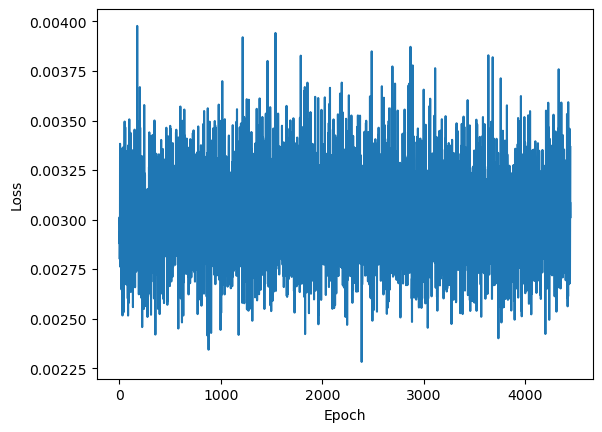

In [ ]:
# plot loss
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();